In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Import Libraries

import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt 
%matplotlib inline
import re
import sys, os, re, csv, codecs
import math
import torch
import torch.nn as nn
import nltk
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import math
!pip install datasets
!pip install transformers

In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.  
    device = torch.device('cuda')    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


#1. Requirement and Business Understanding

- Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

- But, it’s not always clear whether a person’s words are actually announcing a disaster.

- In this project, my objective is build a machine learning model that predicts which Tweets are about real disasters (label 1) and which one’s aren’t (label 0). I’ll have access to a dataset of 10,000 tweets that were hand classified. 

- Criteria for project success is F1_score on test dataset >= 0.7


#2. About Dataset

- This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.

- Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

- Each sample in the train and test set has the following information:

  - The text of a tweet
  - A keyword from that tweet (although this may be blank)
  - The location the tweet was sent from (may also be blank)

- Files: 
  - train.csv - the training set
  - test.csv - the test set
  - sample_submission.csv - a sample submission file in the correct format


- Refenrences
  - https://huggingface.co/transformers/index.html
  - https://www.tensorflow.org/text/tutorials/classify_text_with_bert#define_your_model
  - https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-bert/
  - https://github.com/huggingface/transformers
  - https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

#3. Load Data

- Load the data from CSV file.
- Drop columns have many NaN values. 
- Print out these dataset's description.
- Clean data

In [4]:
!unzip -u "/content/gdrive/MyDrive/nlp-getting-started.zip"

Archive:  /content/gdrive/MyDrive/nlp-getting-started.zip


In [5]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files=['/content/train.csv'])

Using custom data configuration default-db27acc725d255b7
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-db27acc725d255b7/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


In [6]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 7613
    })
})

- Columns
  - id - a unique identifier for each tweet
  - text - the text of the tweet
  - location - the location the tweet was sent from (may be blank)
  - keyword - a particular keyword from the tweet (may be blank)
  - target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

#4. Data Preprocessing

- Do lower text
- Remove Punctuation
- Remove pure number strings
- Remove http...

In [7]:
def processText(examples, target_length = None):

    examples['text'] = examples['text'].lower()

    examples['text'] = re.sub(r'[^\w\s]','', examples['text'])   #remove punctuation

    examples['text'] = re.sub(' \d+', ' ', examples['text'])     #remove pure number strings

    examples['text'] = re.sub(r'http\S+','', examples['text'])   #remove http...

    return examples


In [8]:
dataset = raw_dataset.map(processText)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-db27acc725d255b7/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-be9cb117fa3393d9.arrow


In [9]:
len(dataset['train']['text'])

7613

In [10]:
dataset['train']['text'][0:10]

['our deeds are the reason of this earthquake may allah forgive us all',
 'forest fire near la ronge sask canada',
 'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
 '13000 people receive wildfires evacuation orders in california ',
 'just got sent this photo from ruby alaska as smoke from wildfires pours into a school ',
 'rockyfire update  california hwy  closed in both directions due to lake county fire  cafire wildfires',
 'flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas',
 'im on top of the hill and i can see a fire in the woods',
 'theres an emergency evacuation happening now in the building across the street',
 'im afraid that the tornado is coming to our area']

In [11]:
dataset = dataset.remove_columns(['id','keyword','location'])

#5. Exploratoty Data Analysis

- Common words used in the tweets
- Words in non-disaster tweets
- Words in disaster tweets
- Distribution of tweet labels 

In [12]:
eda_dataset = pd.DataFrame(dataset['train'])

In [13]:
len(eda_dataset)

7613

In [14]:
eda_dataset

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,just got sent this photo from ruby alaska as s...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,aria_ahrary thetawniest the out of control wil...,1
7610,m194 utc5km s of volcano hawaii,1
7611,police investigating after an ebike collided w...,1


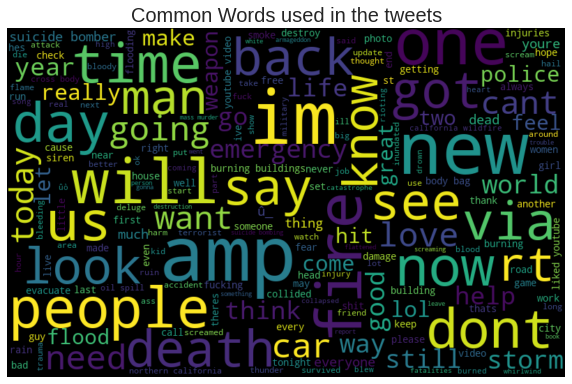

In [15]:
all_words = ' '.join([text for text in eda_dataset['text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Common Words used in the tweets', fontdict={'fontsize': 20})
plt.show()

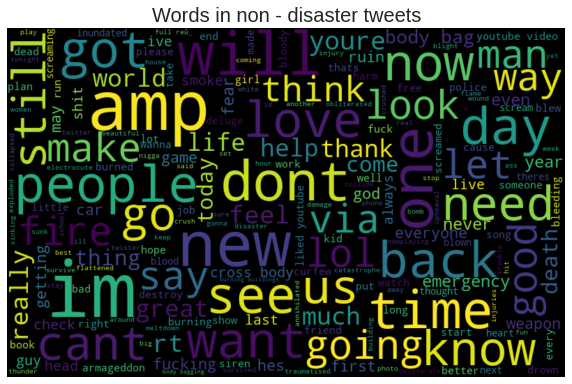

In [16]:
non_disaster_words =' '.join([text for text in eda_dataset['text'][eda_dataset['target'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(non_disaster_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Words in non - disaster tweets', fontdict={'fontsize': 20})
plt.show()

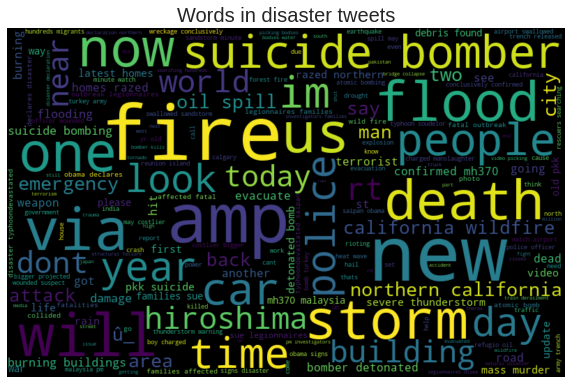

In [17]:
disaster_words = ' '.join([text for text in eda_dataset['text'][eda_dataset['target'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(disaster_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Words in disaster tweets', fontdict={'fontsize': 20})
plt.show()

In [18]:
eda_dataset_target = pd.DataFrame(dataset['train']['target'])

In [19]:
eda_dataset_target.value_counts()

0    4342
1    3271
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


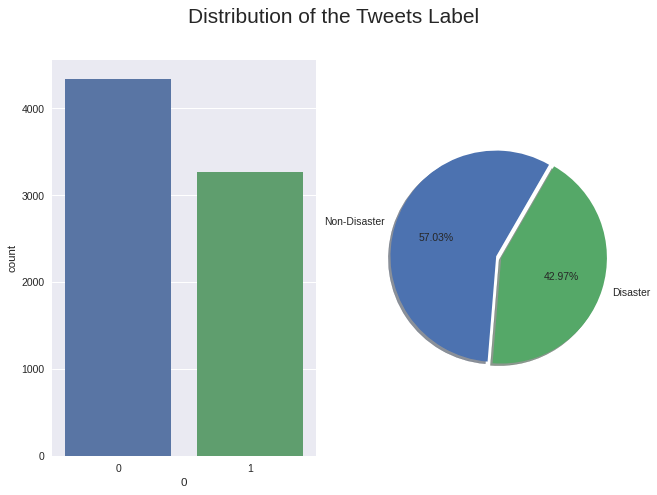

In [20]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,7), dpi= 75)

sns.countplot(eda_dataset_target[0], ax=axes[0])

axes[1].pie(eda_dataset_target[0].value_counts(),
            labels=['Non-Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets Label', fontsize=20)
plt.show()

#6. Data Preparation (Tokenize Data)

- I used Bag-of-words , Word Embedding, TF-IDF features, but as a result, the accuracy is quite low.

- Why use Bert for NLP Text Classification?

  - Originally, simple RNNS (Recurrent Neural Networks) were used for training text data. But in recent years there have been many new research publications that provide state-of-the-art results. One of such is BERT.
  - BERT stands for Bidirectional Encoder Representations from Transformers.
  - BERT applies the bidirectional training of Transformer to language modeling, learns the text representations.
  - BERT is a multi-layered encoder

In [21]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [22]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [23]:
#tokenize data
tokenized_dataset = dataset.map(tokenize_function, batched= True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-db27acc725d255b7/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-d5572eea9b2e7659.arrow


In [24]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'target', 'text', 'token_type_ids'],
        num_rows: 7613
    })
})

In [25]:
#remove the columns corresponding to values the model does not expect (here the "text" column)

tokenized_dataset = tokenized_dataset.remove_columns(['text'])

In [26]:
#rename the column "label" to "labels" (because the model expect the argument to be named labels)

tokenized_dataset = tokenized_dataset.rename_column('target','labels')

In [27]:
tokenized_dataset.set_format('torch')

In [28]:
#Get full dataset

full_dataset = tokenized_dataset['train']

In [29]:
full_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
    num_rows: 7613
})

- Train/Validation Split

In [30]:
full_dataset = full_dataset.train_test_split(test_size=0.2, train_size= 0.8, seed = 42)

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/csv/default-db27acc725d255b7/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-170da8a78802041e.arrow and /root/.cache/huggingface/datasets/csv/default-db27acc725d255b7/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-cd54cba265005434.arrow


In [31]:
full_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 1523
    })
})

In [32]:
train_dataset = full_dataset['train']
train_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
    num_rows: 6090
})

In [33]:
validation_dataset = full_dataset['test']
validation_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
    num_rows: 1523
})

In [34]:
#print length of tokens
len(train_dataset['input_ids'][0])

512

#7. Modeling and Evaluate

- I will fine-tuning a pretrained-model from the Transformers libraby
- Describe model
  - 'bert-base-cased': 12-layer, 768-hidden, 12-heads, 109M parameters. Trained on cased English text.
  - How BERT works: BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. ... As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once.
  - This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).

In [35]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [36]:
#Describe model (only one layer Bert is displayed, actual is 12)

params = list(model.named_parameters())
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.layer.0.attention.output.LayerNor

In [37]:
from transformers import TrainingArguments
training_args = TrainingArguments("trainer", num_train_epochs= 3, 
                                   evaluation_strategy='epoch', save_strategy ='epoch', load_best_model_at_end = True, debug ="underflow_overflow",
                                   metric_for_best_model = 'f1',
                                   per_device_train_batch_size = 8, per_device_eval_batch_size = 8)

In [38]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1} 

In [39]:
from transformers import Trainer
trainer = Trainer(
    model = model, args= training_args, train_dataset= train_dataset, eval_dataset=validation_dataset, compute_metrics = compute_metrics )

In [40]:
trainer.train()

***** Running training *****
  Num examples = 6090
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2286


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.492600,0.487125,0.755089,0.662005,0.872504,0.752816
2,0.386600,0.453832,0.824688,0.840426,0.728111,0.780247
3,0.307000,0.649839,0.818779,0.801932,0.764977,0.783019


***** Running Evaluation *****
  Num examples = 1523
  Batch size = 8
Saving model checkpoint to trainer/checkpoint-762
Configuration saved in trainer/checkpoint-762/config.json
Model weights saved in trainer/checkpoint-762/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1523
  Batch size = 8
Saving model checkpoint to trainer/checkpoint-1524
Configuration saved in trainer/checkpoint-1524/config.json
Model weights saved in trainer/checkpoint-1524/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1523
  Batch size = 8
Saving model checkpoint to trainer/checkpoint-2286
Configuration saved in trainer/checkpoint-2286/config.json
Model weights saved in trainer/checkpoint-2286/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from trainer/checkpoint-2286 (score: 0.7830188679245284).


TrainOutput(global_step=2286, training_loss=0.393287214811497, metrics={'train_runtime': 2244.6287, 'train_samples_per_second': 8.139, 'train_steps_per_second': 1.018, 'total_flos': 4807038981427200.0, 'train_loss': 0.393287214811497, 'epoch': 3.0})

#8. Predict on test dataset

In [41]:
#Load test dataset

raw_dataset_test = load_dataset('csv', data_files=['/content/test.csv'])
raw_dataset_test

Using custom data configuration default-56d177af19f26f2a
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-56d177af19f26f2a/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text'],
        num_rows: 3263
    })
})

In [42]:
#preprocess test dataset

dataset_test = raw_dataset_test.map(processText)
raw_dataset_test

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-56d177af19f26f2a/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-847070eb8021c8f2.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text'],
        num_rows: 3263
    })
})

In [43]:
#tokenize test dataset

tokenized_dataset_test = dataset_test.map(tokenize_function, batched= True)
tokenized_dataset_test = tokenized_dataset_test.remove_columns(['id','keyword','location'])
tokenized_dataset_test

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-56d177af19f26f2a/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-f295998e72977783.arrow


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text', 'token_type_ids'],
        num_rows: 3263
    })
})

In [44]:
test_dataset = tokenized_dataset_test['train']
test_dataset = test_dataset.remove_columns(['text'])
test_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'token_type_ids'],
    num_rows: 3263
})

In [45]:
hist_test = trainer.predict(test_dataset= test_dataset)

#Returns: NamedTuple A namedtuple with the following keys:
#  predictions (np.ndarray): The predictions on test_dataset.
#  label_ids (np.ndarray, optional): The labels (if the dataset contained some).
#  metrics (Dict[str, float], optional): The potential dictionary of metrics (if the dataset contained labels).

***** Running Prediction *****
  Num examples = 3263
  Batch size = 8


In [46]:
test_prediction = hist_test.predictions
test_prediction = test_prediction.argmax(axis = 1)

#print test prediction
test_prediction

array([1, 1, 1, ..., 1, 1, 1])

In [47]:
sample = pd.read_csv('/content/sample_submission.csv')
test_groundtruth = np.array(sample['target'])

#print test_groundtruth
test_groundtruth

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

#Compute Matrix
def compute_confusion_matrix(groundtruth, prediction):
    
    cnf_matrix = confusion_matrix(groundtruth, prediction)
    return cnf_matrix

class_names = ['non-disaster', 'disaster']
cnf_matrix = compute_confusion_matrix(test_groundtruth, test_prediction)

#Classification report and f1_score on test dataset
print(classification_report(test_groundtruth, test_prediction))

test_f1 = f1_score(test_groundtruth, test_prediction, average='weighted')
print('F1_score on test dataset is: ' + str(test_f1))

              precision    recall  f1-score   support

           0       1.00      0.61      0.76      3263
           1       0.00      0.00      0.00         0

    accuracy                           0.61      3263
   macro avg       0.50      0.30      0.38      3263
weighted avg       1.00      0.61      0.76      3263

F1_score on test dataset is: 0.7564786585365855


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Submit to Kaggle Competition

In [49]:
tanlee_submission = pd.DataFrame({'id': sample['id'], 'target': test_prediction})

filename = 'tanlee_submission.csv'
tanlee_submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: tanlee_submission.csv


In [50]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# submit the file to kaggle
!kaggle competitions submit -c nlp-getting-started -f tanlee_submission.csv -m "Final"

100% 22.2k/22.2k [00:00<00:00, 106kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

In [51]:
print('Public score on Kaggle is:  0.81489')

Public score on Kaggle is:  0.79711


#9. Improvement and Conlclusion

In [52]:
#Empty cache
torch.cuda.empty_cache()

In [53]:
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 1.6 GB
Cached:    2.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


- Criteria for project success is F1_score on test dataset >= 0.7 and I reached through fine-tuning a pre-trained model above. And I want to improve model to get higher score.

- Improve model (used but not display in this notebooks:)
  - Using larger model architecture (bert-large-cased, or add layers into model), but gpu is not enough.
  - Using model_init() then hyperparameter_search to optimize parameters in training_agrs
  - Using word embedding, tf-idf to extract features (in part: tokenize_data) but accuracy is low.

- Improve model (using): Decrease batch size: 8 --> 2

In [ ]:
training_args = TrainingArguments("improve_trainer", num_train_epochs= 3, 
                                   evaluation_strategy='epoch', save_strategy ='epoch', load_best_model_at_end = True, debug ="underflow_overflow",
                                   metric_for_best_model = 'f1',
                                   per_device_train_batch_size = 2, per_device_eval_batch_size = 2)

improve_trainer = Trainer(
    model = model, args= training_args, train_dataset= train_dataset, eval_dataset=validation_dataset, compute_metrics = compute_metrics
)

In [ ]:
improve_trainer.train()

***** Running training *****
  Num examples = 6090
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 9135


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.683300,0.755306,0.430729,0.428854,1.000000,0.600277
2,0.690100,0.681930,0.572554,0.000000,0.000000,0.000000


***** Running Evaluation *****
  Num examples = 1523
  Batch size = 2
Saving model checkpoint to improve_trainer/checkpoint-3045
Configuration saved in improve_trainer/checkpoint-3045/config.json
Model weights saved in improve_trainer/checkpoint-3045/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1523
  Batch size = 2
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to improve_trainer/checkpoint-6090
Configuration saved in improve_trainer/checkpoint-6090/config.json
Model weights saved in improve_trainer/checkpoint-6090/pytorch_model.bin


In [ ]:
#predict
improve_hist_test = improve_trainer.predict(test_dataset= test_dataset)

improve_test_prediction = improve_hist_test.predictions

improve_test_prediction = improve_test_prediction.argmax(axis = 1)

#compute cnf_matrix
improve_cnf_matrix = compute_confusion_matrix(test_groundtruth, improve_test_prediction)
print(classification_report(test_groundtruth, improve_test_prediction))


improve_test_f1 = f1_score(test_groundtruth, improve_test_prediction, average='weighted')
print('Improve F1_score on test dataset is: ' + str(improve_test_f1))

In [ ]:
improve_tanlee_submission = pd.DataFrame({'id': sample['id'], 'target': improve_test_prediction})

filename = 'improve_tanlee_submission.csv'

improve_tanlee_submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

# submit the file to kaggle
!kaggle competitions submit -c nlp-getting-started -f improve_tanlee_submission.csv -m "Improve_Final"

In [ ]:
print('Improve public score on Kaggle is:  ')

- Conclusion: 

  - I have taken the steps of a project about predicts which Tweets are about real disasters (label 1) and which one’s aren’t (label 0)

  - Include: Search, Collect and Preprocess Data, Expolatory data, Modelling data (using Bert) and Evaluate model.

  - I also reached criteria for project success is F1_score on test dataset >= 0.7

  - Final, I used several methods to improve my model.

  - And BERT was able to improve the accuracy (or F1-score) on many Natural Language Processing and Language Modelling tasks